In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from FeatureEngineering_2 import *
from joblib import dump, load
from AdvancedModel_helpers import *
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import VarianceThreshold

In [ ]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

In [5]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df = train_val_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df.reset_index(drop=True)

Loading files: 100%|██████████| 4/4 [00:01<00:00,  3.08file/s]


### Load datas and One-Hot encoding

In [6]:
train_val_df=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'is_goal']]

In [7]:
train_val_shot_type_oh = onehot_generator(train_val_df[['shot_type']])
train_val_last_event_type_oh = onehot_generator(train_val_df[['last_event_type']])
train_val_df= train_val_df.drop(columns=['shot_type','last_event_type'])
train_val_df = pd.concat([train_val_df,
                       train_val_shot_type_oh.set_index(train_val_df.index),
                       train_val_last_event_type_oh.set_index(train_val_df.index)],axis=1)

In [8]:
train_val_df

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
0,71,1,-77.0,5.0,-61.0,11.0,1,17.088007,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,173,1,86.0,13.0,54.0,-5.0,5,36.715120,False,NaN,...,0,0,0,0,0,0,0,0,0,0
2,241,1,23.0,-38.0,-72.0,0.0,18,102.318131,False,NaN,...,1,0,0,0,0,0,0,0,0,0
3,286,1,33.0,-15.0,77.0,-2.0,19,45.880279,False,NaN,...,1,0,0,0,0,0,0,0,0,0
4,406,1,-34.0,28.0,47.0,34.0,16,81.221918,False,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305809,1045,3,77.0,-23.0,-72.0,-21.0,21,149.013422,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305810,1080,3,-76.0,38.0,-95.0,-17.0,16,58.189346,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305811,1082,3,-79.0,10.0,-76.0,38.0,2,28.160256,True,26.113913,...,0,0,0,0,0,0,0,1,0,0
305812,1170,3,81.0,-7.0,-60.0,40.0,32,148.627050,False,NaN,...,1,0,0,0,0,0,0,0,0,0


In [9]:
train_val_df = train_val_df.drop(columns=['change_shot_angle'])

In [10]:
train_val_df = train_val_df.dropna()

In [11]:
len(train_val_df )

288551

In [12]:
train_X,train_Y,val_X,val_Y = split_data(train_val_df,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'Speed',
       'shot_dist','angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.20,False)

### Data Pre-processing
Using Variance filter to filter low variance features

In [13]:
selector = VarianceThreshold(0.8 *(1-0.8))
X_train_pre = selector.fit_transform(train_X)
train_X_1 = train_X.loc[:,selector.get_support()]

In [17]:
val_X_1 = val_X.loc[:,selector.get_support()]

In [14]:
from sklearn import tree

In [24]:
clf = tree.DecisionTreeClassifier()

In [25]:
clf.fit(train_X_1,train_Y)

DecisionTreeClassifier()

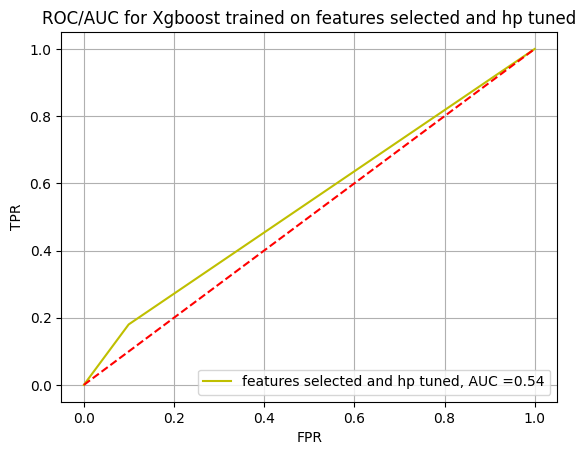

In [26]:
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y,clf.predict_proba(val_X_1),'Xgboost','features selected and hp tuned')